# Drug Consumption

Dieses Notebook wird im Rahmen der Vorlesung Data Exploration Project angefertigt.
Beteiligte Personen an der Ausarbeitung sind Salih Kelmendi und Luis Rastetter.
Das Ziel dieser Ausarbeitung ist das Trainieren und Vergleichen verschiedener
Modelle, welche im Rahmen der Machine Learning Fundamentals im 3. Semester
behandelt wurden, sodass die in im zugehörigen Projektbericht aufgeführte Zielsetzung erreicht werden kann.
Der Vergleich jener Modelle erfolgt anhand verschiedener Metriken, wie in der Dokumentation und auch in späteren Codeabschnitten ersichtlich wird. 
Der gesamte Verlauf der Ausarbeitung orientiert sich am Cross-Industry Standard Process for Data Mining.

`Hinweis:` Die Kapitelbenennung und Reihenfolge der Codeabschnitte kann im Vergleich zum Projektbericht abweichen. Ebenfalls wurde die Data Preparation hier im      Notebook nicht als eigenes Kapitel aufgefasst und erfolgt innerhalb des Data Understandings und Modellings.


## 1. Data Understanding
### 1.1 Import von benötigten Bibliotheken
Hier werden alle notwendigen Bibliotheken für Datenverarbeitung, Modelltraining und Visualisierung importiert. Dazu gehören:
- `pandas` und `numpy` für die Datenmanipulation,
- `sklearn` für Machine Learning Modelle und Metriken,
- `matplotlib` und `seaborn` für die Visualisierung,
- `statsmodels` für statistische Analyse.

In [39]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import statsmodels.api as sm
import numpy as np

### 1.2 Datensatz abrufen

Der UCI-Datensatz „Drug Consumption (quantified)“ wird direkt mit `fetch_ucirepo()` geladen. Danach werden Features (`X`) und Zielvariable (`y`) definiert.


In [40]:
dataset = fetch_ucirepo(id=373)
X = dataset.data.features
y = dataset.data.targets

### 1.3 Datenübersicht und Vorbereitung

Zunächst wird ein Überblick über die verfügbaren Merkmale und Zielvariablen gegeben.  
Die Merkmale **`gender`** und **`ethnicity`** wurden dabei aus dem Datensatz entfernt, da sie für unsere Modellierung keine starke inhaltliche Relevanz haben und potenziell zu Verzerrungen führen könnten.

Es folgen erste Einblicke in die Datenstruktur durch Anzeige der ersten Zeilen sowie der Datentypen.

Anschließend wird der Datensatz weiter aufbereitet, um ihn für das Modelltraining vorzubereiten. Dazu gehören Schritte wie:
- Aufteilen in Trainings- und Testdaten,
- Prüfung auf Duplikate oder fehlende Werte,

Zur weiteren Exploration werden Lage- und Streuungsmaße der Merkmale berechnet und visualisiert.  
Boxplots, Histogramme und Violinplots helfen dabei, Ausreißer, Verteilungen und Unterschiede zwischen den Merkmalen besser zu erkennen.

In [41]:
print("Anzahl Duplikate im Datensatz: ", sum(X.duplicated()))

if sum(X.duplicated()) == 0: 
    print("Keine Duplikate im Datensatz.")

Anzahl Duplikate im Datensatz:  0
Keine Duplikate im Datensatz.


In [42]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1885 non-null   float64
 1   gender     1885 non-null   float64
 2   education  1885 non-null   float64
 3   country    1885 non-null   float64
 4   ethnicity  1885 non-null   float64
 5   nscore     1885 non-null   float64
 6   escore     1885 non-null   float64
 7   oscore     1885 non-null   float64
 8   ascore     1885 non-null   float64
 9   cscore     1885 non-null   float64
 10  impuslive  1885 non-null   float64
 11  ss         1885 non-null   float64
dtypes: float64(12)
memory usage: 176.8 KB
None


In [43]:

print(X.head())
X = dataset.data.features.drop(columns=['gender', 'ethnicity'], errors='ignore')

print("Übersicht der Merkmale:")
print(X.head())

print("")
print("Übersicht der Targets in den Zielklassen:")
print(y.head())

print("")
print("Übersicht über Datentypen im Datensatz")
print(X.dtypes)
print(y.dtypes)

       age   gender  education  country  ethnicity   nscore   escore   oscore  \
0  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545 -0.58331   
1 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886  1.43533   
2  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523 -0.84732   
3 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615 -0.01928   
4  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340 -0.45174   

    ascore   cscore  impuslive       ss  
0 -0.91699 -0.00665   -0.21712 -1.18084  
1  0.76096 -0.14277   -0.71126 -0.21575  
2 -1.62090 -1.01450   -1.37983  0.40148  
3  0.59042  0.58489   -1.37983 -1.18084  
4 -0.30172  1.30612   -0.21712 -0.21575  
Übersicht der Merkmale:
       age  education  country   nscore   escore   oscore   ascore   cscore  \
0  0.49788   -0.05921  0.96082  0.31287 -0.57545 -0.58331 -0.91699 -0.00665   
1 -0.07854    1.98437  0.96082 -0.67825  1.93886  1.43533  0.76096 -0.14277   


### 1.4 Ausgabe der Lage- und Streuungsmaße

Lage- und Streuungsmaße der Features:
              age    education      country       nscore       escore  \
count  1885.00000  1885.000000  1885.000000  1885.000000  1885.000000   
mean      0.03461    -0.003806     0.355542     0.000047    -0.000163   
std       0.87836     0.950078     0.700335     0.998106     0.997448   
min      -0.95197    -2.435910    -0.570090    -3.464360    -3.273930   
25%      -0.95197    -0.611130    -0.570090    -0.678250    -0.695090   
50%      -0.07854    -0.059210     0.960820     0.042570     0.003320   
75%       0.49788     0.454680     0.960820     0.629670     0.637790   
max       2.59171     1.984370     0.960820     3.273930     3.273930   

            oscore       ascore       cscore    impuslive           ss  
count  1885.000000  1885.000000  1885.000000  1885.000000  1885.000000  
mean     -0.000534    -0.000245    -0.000386     0.007216    -0.003292  
std       0.996229     0.997440     0.997523     0.954435     0.963701  
min      -3.

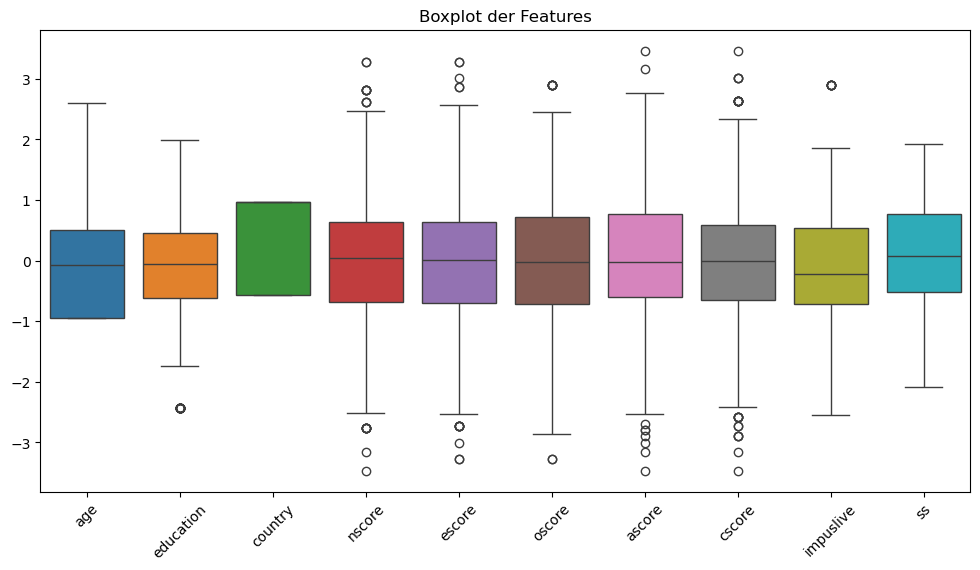

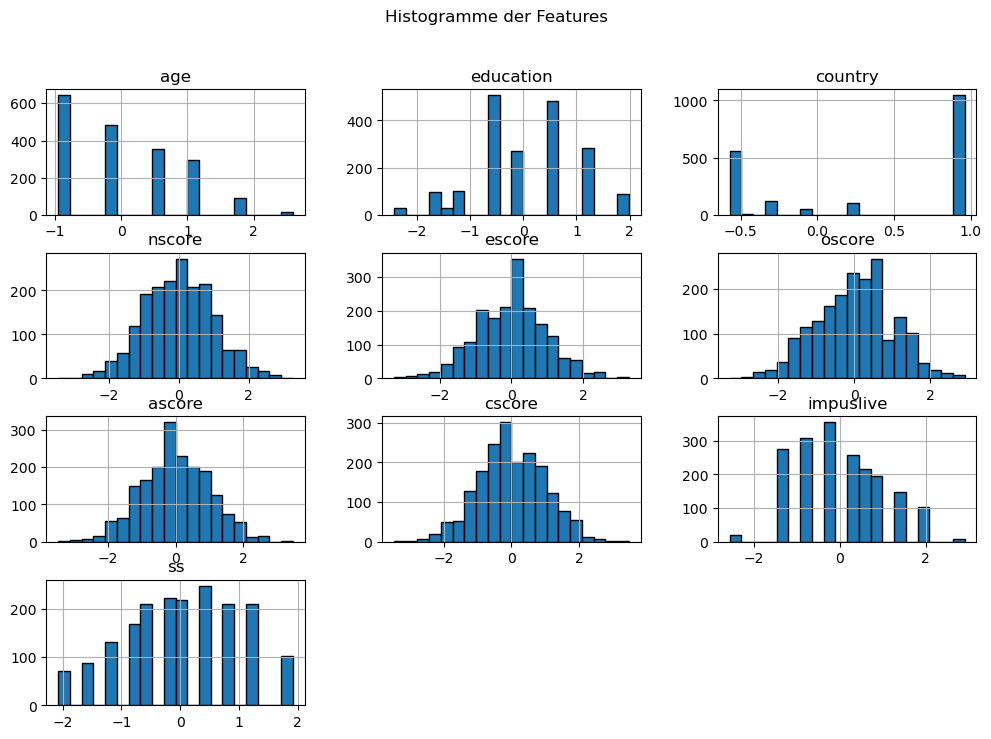

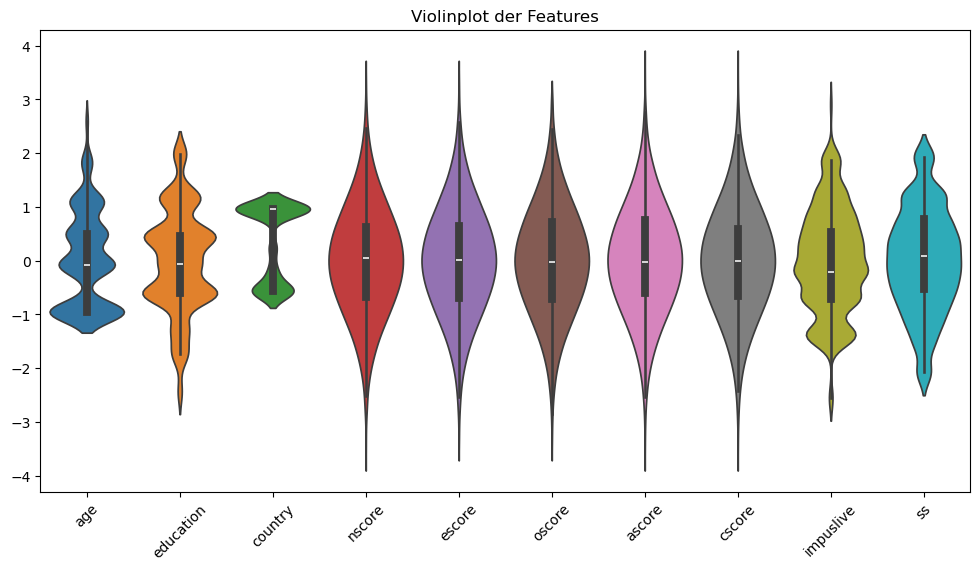

In [44]:
print("Lage- und Streuungsmaße der Features:")
print(X.describe())

plt.figure(figsize=(12, 6))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.title("Boxplot der Features")
plt.show()

X.hist(figsize=(12, 8), bins=20, edgecolor="black")
plt.suptitle("Histogramme der Features")
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(data=X)
plt.xticks(rotation=45)
plt.title("Violinplot der Features")
plt.show()

### 1.5 Enthaltene Drogen im Datensatz

Für unser Projekt konzentrieren wir uns aus zeitlichen Gründen auf drei ausgewählte Drogen: **Cannabis**, **Kokain** und **Nikotin**.

Diese Auswahl wurde bewusst getroffen:

- **Cannabis**  
  Eine weit verbreitete Alltagsdroge, die in vielen Ländern legal ist, jedoch nicht überall. Sie steht exemplarisch für gesellschaftlich teilweise akzeptierte, aber nicht unumstrittene Substanzen.

- **Kokain**  
  Eine harte, illegale Droge mit hohem Gefahrenpotenzial, die selten konsumiert wird und kaum Teil des Alltags ist.

- **Nikotin**  
  Eine legale Substanz, die für viele Menschen fest zum Alltag gehört – trotz bekannter gesundheitlicher Risiken.


In [45]:
drug_columns = ['cannabis', 'coke', 'ecstasy', 'heroin', 'meth', 'mushrooms', 'nicotine', 'lsd', 'amphet', 'crack', 'alcohol']
chosen_drugs = ['cannabis', 'coke', 'nicotine'] 

### 1.6 Visualisierung der Konsumverteilung

Für jede ausgewählte Droge wird die Verteilung der Konsumkategorien dargestellt. So lässt sich erkennen, wie häufig bestimmte Konsumstufen in der Stichprobe vertreten sind.

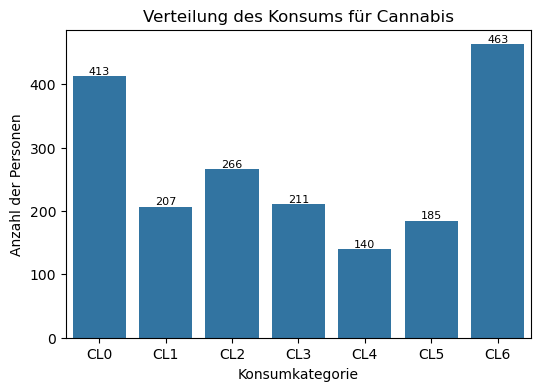

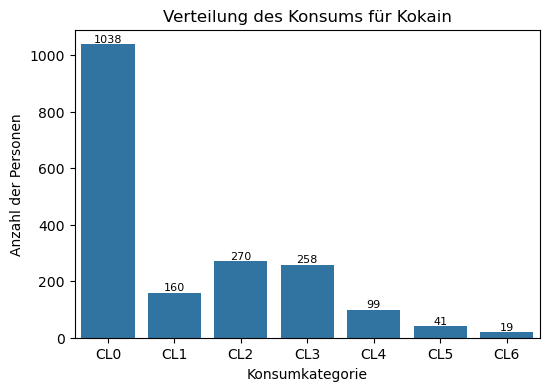

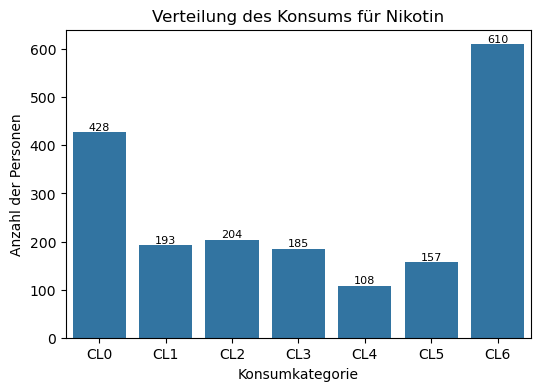

In [46]:
drug_names = {
    'cannabis': 'Cannabis',
    'coke': 'Kokain',
    'nicotine': 'Nikotin',
}

for drug in chosen_drugs:
    plt.figure(figsize=(6, 4))
    
    value_counts = y[drug].value_counts().sort_values(ascending=False)
    
    ordered_categories = ['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6']
    
    ax = sns.countplot(x=y[drug], order=ordered_categories)
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height,  
                f'{int(height)}', ha="center", va="bottom", fontsize=8)
    
    plt.title(f"Verteilung des Konsums für {drug_names.get(drug, drug).capitalize()}")
    plt.xlabel('Konsumkategorie')
    plt.ylabel('Anzahl der Personen')
    plt.show()

In [47]:
drug_names = ['cannabis', 'coke', 'nicotine']
y_selected = y[drug_names]

### 1.7 Aufteilung in Trainings- und Testdaten

Die Daten werden im Verhältnis 80/20 aufgeteilt. 80 % dienen dem Modelltraining, 20 % der späteren Modellbewertung auf unbekannten Daten.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y_selected, test_size=0.2, random_state=42)

In [49]:
print("\nTrainingsdaten (Features) : ", X_train.shape)
print("Testdaten (Features) : ", X_test.shape)


Trainingsdaten (Features) :  (1508, 10)
Testdaten (Features) :  (377, 10)


### 1.8 Entscheidungsbaum mit Grid Search

Für jede ausgewählte Droge wird ein Entscheidungsbaum mithilfe von Grid Search optimiert. Dabei wird eine systematische Suche nach den besten Hyperparametern durchgeführt.  
Zur Bewertung der Modelle wird der F1-Score (macro) verwendet, um alle Klassen gleich zu gewichten.  
Class Weights werden berücksichtigt, um Klassendiskrepanzen auszugleichen.


In [50]:
from sklearn.model_selection import GridSearchCV
dt_models = {}
y_pred_dt = {}
best_params_dt = {}
for drug in drug_names:
    print(f"Grid Search für {drug} läuft...")
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 10, 15] if drug in ['coke', 'nicotine'] else [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = DecisionTreeClassifier(
        random_state=42,
        class_weight=class_weight_dict
    )
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=3,
        scoring='f1_macro',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train[drug])
    best_model = grid_search.best_estimator_

    dt_models[drug] = best_model
    y_pred_dt[drug] = best_model.predict(X_test)
    best_params_dt[drug] = grid_search.best_params_
    print(f"Beste Parameter für {drug}: {grid_search.best_params_}")


Grid Search für cannabis läuft...
Beste Parameter für cannabis: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}
Grid Search für coke läuft...
Beste Parameter für coke: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Grid Search für nicotine läuft...
Beste Parameter für nicotine: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


## 2. Modellierung

Zur Vorhersage des Drogenkonsums wurden fünf verschiedene Klassifikationsmodelle implementiert. Für jedes Modell wurde ein individueller Klassifikator für jede Droge (Cannabis, Kokain, Nikotin) trainiert. Bei allen Modellen – außer KNN – wurden zudem Klassenungleichgewichte über Gewichtungen berücksichtigt.

#### Modell 1: Entscheidungsbaum (Decision Tree)

Ein einfacher, interpretierbarer Klassifikator, der hier mit festen Parametern trainiert wurde. Für jede Droge wurden die Parameter wie `max_depth`, `criterion`, `min_samples_split` und `min_samples_leaf` angepasst. Klassenungleichgewichte wurden durch Gewichtung berücksichtigt.

#### Modell 2: Random Forest

Ein Ensemble-Modell, das mehrere Entscheidungsbäume kombiniert, um stabilere Vorhersagen zu liefern. Es wurde mit 100 Bäumen (`n_estimators=100`) und einer maximalen Tiefe von 10 trainiert. Auch hier wurde auf balancierte Klassenverteilungen geachtet.

#### Modell 3: Logistische Regression

Ein lineares Modell zur Klassifikation, das gut mit großen, hochdimensionalen Datensätzen funktioniert. Es wurde mit einer Begrenzung auf 50 Iterationen trainiert. Klassenungleichgewichte wurden erneut durch Gewichtung berücksichtigt.

#### Modell 4: K-Nearest Neighbors (KNN)

Ein instanzbasiertes Verfahren, das Klassenzugehörigkeit auf Basis der nächsten Nachbarn bestimmt. Es wurde mit 11 Nachbarn und distanzbasierter Gewichtung eingesetzt. Dieses Modell berücksichtigt keine Gewichtung der Klassen, ist aber durch seine Einfachheit robust gegenüber Rauschen.

#### Modell 5: Support Vector Machine (SVM)

Ein lineares SVM-Modell, das besonders bei hoher Dimensionalität gute Ergebnisse erzielen kann. Es wurde mit einem linearen Kernel und balancierten Klassen gewichtet trainiert. Aufgrund der Komplexität kann es jedoch rechenintensiver sein.

Jedes Modell wurde separat für jede der drei Drogen trainiert und evaluiert. So lassen sich die Vorhersagefähigkeiten drogenspezifisch vergleichen.

### 2.1 Decision Tree 


In [51]:
dt_models = {}
y_pred_dt = {}

for drug in drug_names:
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    
    dt_model = DecisionTreeClassifier(
        random_state=42,
        class_weight=class_weight_dict,
        criterion='entropy',
        max_depth=10 if drug in ['coke', 'nicotine'] else 5,
        min_samples_leaf=1,
        min_samples_split=2
    )
    
    dt_model.fit(X_train, y_train[drug])
    dt_models[drug] = dt_model
    y_pred_dt[drug] = dt_model.predict(X_test)


### 2.2 Random Forest

In [52]:
rf_models = {}
y_pred_rf = {}

for drug in drug_names:
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    
    rf_model = RandomForestClassifier(random_state=42, 
                                  class_weight=class_weight_dict, 
                                  n_estimators=100,
                                  max_depth=10)
    rf_model.fit(X_train, y_train[drug])

    y_pred_rf[drug] = rf_model.predict(X_test)
    rf_models[drug] = rf_model


### 2.3 Logistische Regression


In [53]:
logreg_models = {}
y_pred_logreg = {}

for drug in drug_names:
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    
    logreg_model = LogisticRegression(max_iter=50, class_weight=class_weight_dict, random_state=42)
    logreg_model.fit(X_train, y_train[drug])
    
    y_pred_logreg[drug] = logreg_model.predict(X_test)
    logreg_models[drug] = logreg_model

### 2.4 KNN

In [54]:
knn_models = {}
y_pred_knn = {}
for drug in drug_names:
    knn_model = KNeighborsClassifier(
        algorithm='auto',
        leaf_size=20,
        n_neighbors=11,
        p=1,
        weights='distance'
    )
    knn_model.fit(X_train, y_train[drug])    
    y_pred_knn[drug] = knn_model.predict(X_test)
    knn_models[drug] = knn_model


### 2.5 SVM Modell

In [55]:
svm_models = {}
y_pred_svm = {}

for drug in drug_names:    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    
    svm_model = SVC(kernel='linear', class_weight=class_weight_dict, random_state=42)
    svm_model.fit(X_train, y_train[drug])
    
    y_pred_svm[drug] = svm_model.predict(X_test)
    svm_models[drug] = svm_model

### 2.6 Modellbewertung

Zur Bewertung der Modellleistung wurden verschiedene Metriken herangezogen:

- **Accuracy**: misst den Anteil korrekt vorhergesagter Klassen.
- **F1-Score (macro)**: berücksichtigt sowohl Präzision als auch Recall und gewichtet alle Klassen gleich.
- **Trainings- und Testfehler**: zeigen, wie gut das Modell auf die Trainingsdaten passt und wie gut es auf neuen Daten generalisiert.

Die Berechnungen erfolgen für jedes Modell und jede Droge getrennt. Für Logistische Regression und Entscheidungsbaum wird zusätzlich ein vollständiger Klassifikationsbericht ausgegeben.

Anschließend werden die Ergebnisse visuell aufbereitet. Pro Droge wird ein Diagramm erstellt, das die Performance der fünf Modelle anhand der vier Kennzahlen (Accuracy, F1-Score, Trainingsfehler, Testfehler) vergleicht.

In [56]:
all_accuracies = {}
all_f1_scores = {}
all_classification_reports = {}
all_train_errors = {}
all_test_errors = {}

for drug in drug_names:
    print(f"\nErgebnisse für {drug}:")

    models = {
        "Random Forest": rf_models[drug],
        "Logistische Regression": logreg_models[drug],
        "SVM": svm_models[drug],
        "Decision Tree": dt_models[drug],
        "KNN": knn_models[drug]
    }

    accuracies, f1_scores_dict, classification_reports, train_errors, test_errors = {}, {}, {}, {}, {}

    for model_name, model in models.items():
        predictions = model.predict(X_test)
        accuracies[model_name] = accuracy_score(y_test[drug], predictions)
        f1_scores_dict[model_name] = f1_score(y_test[drug], predictions, average='macro')

        if model_name in ["Logistische Regression", "Decision Tree"]:
            classification_reports[model_name] = classification_report(
                y_test[drug], predictions, zero_division=0
            )

        train_predictions = model.predict(X_train)
        train_errors[model_name] = 1 - accuracy_score(y_train[drug], train_predictions)
        test_errors[model_name] = 1 - accuracies[model_name]

    all_accuracies[drug] = accuracies
    all_f1_scores[drug] = f1_scores_dict
    all_classification_reports[drug] = classification_reports
    all_train_errors[drug] = train_errors
    all_test_errors[drug] = test_errors

    print("\nKlassifikationsberichte:")
    for model_name in ["Logistische Regression", "Decision Tree"]:
        if model_name in classification_reports:
            print(f"\n{model_name}:")
            print(classification_reports[model_name])



Ergebnisse für cannabis:

Klassifikationsberichte:

Logistische Regression:
              precision    recall  f1-score   support

         CL0       0.52      0.45      0.48        86
         CL1       0.20      0.50      0.29        28
         CL2       0.19      0.18      0.18        55
         CL3       0.30      0.18      0.22        57
         CL4       0.09      0.11      0.10        27
         CL5       0.10      0.16      0.12        32
         CL6       0.52      0.34      0.41        92

    accuracy                           0.30       377
   macro avg       0.27      0.27      0.26       377
weighted avg       0.35      0.30      0.31       377


Decision Tree:
              precision    recall  f1-score   support

         CL0       0.34      0.20      0.25        86
         CL1       0.15      0.50      0.23        28
         CL2       0.33      0.20      0.25        55
         CL3       0.21      0.25      0.22        57
         CL4       0.04      0.04      

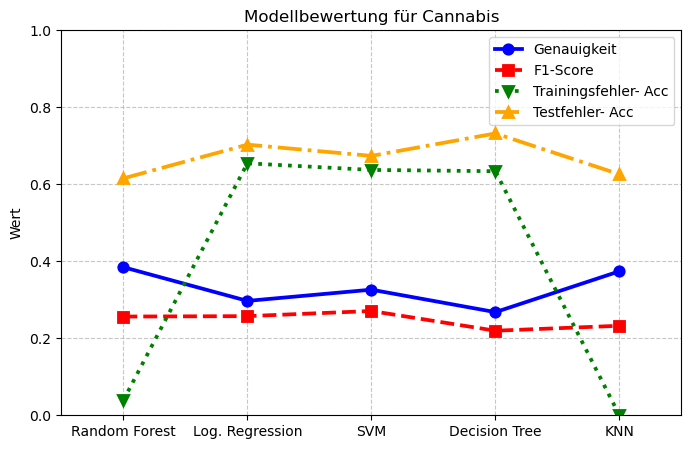

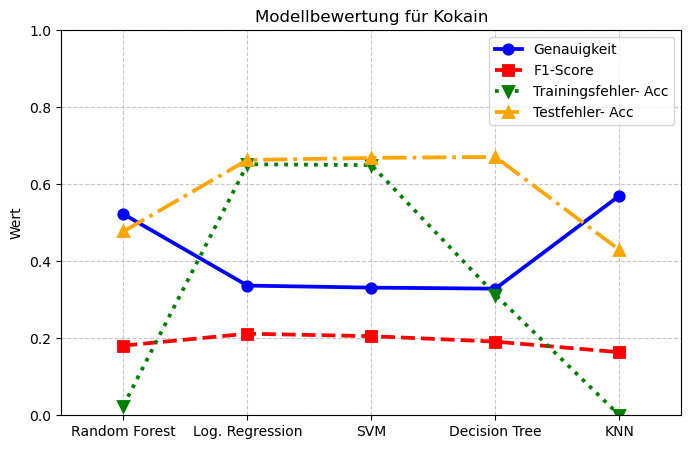

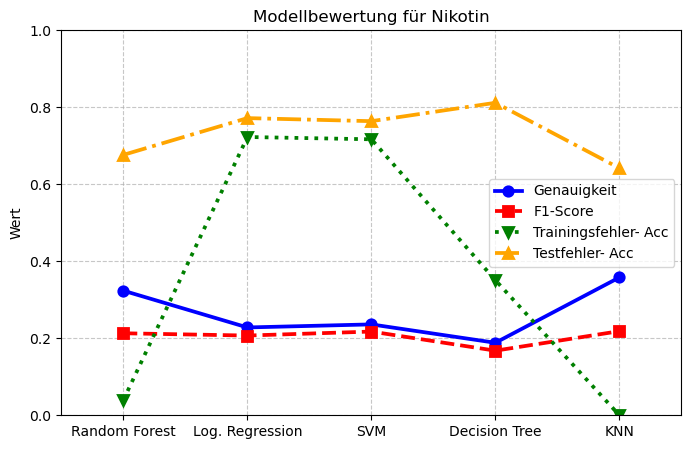

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ["Random Forest", "Log. Regression", "SVM", "Decision Tree", "KNN"]

for drug in drug_names:
    if drug == "cannabis":
        drug_title = "Modellbewertung für Cannabis"
    elif drug == "coke":
        drug_title = "Modellbewertung für Kokain"
    elif drug == "nicotine":
        drug_title = "Modellbewertung für Nikotin"
    else:
        drug_title = f"Modellbewertung für {drug}"

    accuracies = [
        all_accuracies[drug]["Random Forest"],
        all_accuracies[drug]["Logistische Regression"],
        all_accuracies[drug]["SVM"],
        all_accuracies[drug]["Decision Tree"],
        all_accuracies[drug]["KNN"]
    ]
    
    f1_scores = [
        all_f1_scores[drug]["Random Forest"],
        all_f1_scores[drug]["Logistische Regression"],
        all_f1_scores[drug]["SVM"],
        all_f1_scores[drug]["Decision Tree"],
        all_f1_scores[drug]["KNN"]
    ]

    train_errors = [
        all_train_errors[drug]["Random Forest"],
        all_train_errors[drug]["Logistische Regression"],
        all_train_errors[drug]["SVM"],
        all_train_errors[drug]["Decision Tree"],
        all_train_errors[drug]["KNN"]
    ]

    test_errors = [
        all_test_errors[drug]["Random Forest"],
        all_test_errors[drug]["Logistische Regression"],
        all_test_errors[drug]["SVM"],
        all_test_errors[drug]["Decision Tree"],
        all_test_errors[drug]["KNN"]
    ]

    plt.figure(figsize=(8, 5))
    sns.pointplot(x=models, y=accuracies, color="blue", marker="o", linestyle="-", label="Genauigkeit")
    sns.pointplot(x=models, y=f1_scores, color="red", marker="s", linestyle="--", label="F1-Score")
    sns.pointplot(x=models, y=train_errors, color="green", marker="v", linestyle=":", label="Trainingsfehler- Acc")
    sns.pointplot(x=models, y=test_errors, color="orange", marker="^", linestyle="-.", label="Testfehler- Acc")
    plt.ylabel("Wert")
    plt.ylim(0, 1)
    plt.title(drug_title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


### 2.7 Merkmalswichtigkeit

Zur Interpretation der Modelle wurde analysiert, welche Merkmale den größten Einfluss auf die Vorhersage des Drogenkonsums haben.  
Ziel ist es, nachvollziehbar zu machen, welche Faktoren besonders relevant für die Klassifikation sind.

#### 2.7.1 Entscheidungsbaum & Random Forest

Bei baumbasierten Modellen wie dem Entscheidungsbaum und dem Random Forest kann direkt auf die `feature_importances_`-Eigenschaft zugegriffen werden.  
Diese gibt an, wie stark jedes Merkmal zur Entscheidungsfindung beigetragen hat. Die Gewichtungen werden dabei für ein Modell berechnet und grafisch dargestellt.

#### 2.7.2 Logistische Regression

Auch bei der logistischen Regression lassen sich die Merkmalsgewichtungen anhand der Modellkoeffizienten interpretieren.  
Für jede Droge wurde ein Modell trainiert und die Koeffizienten extrahiert. Anschließend wurden diese mittleren Gewichtungen über alle drei Drogen hinweg gemittelt und visualisiert.  
So wird deutlich, welche Merkmale im Durchschnitt den größten positiven oder negativen Einfluss auf die Vorhersagewahrscheinlichkeit haben.


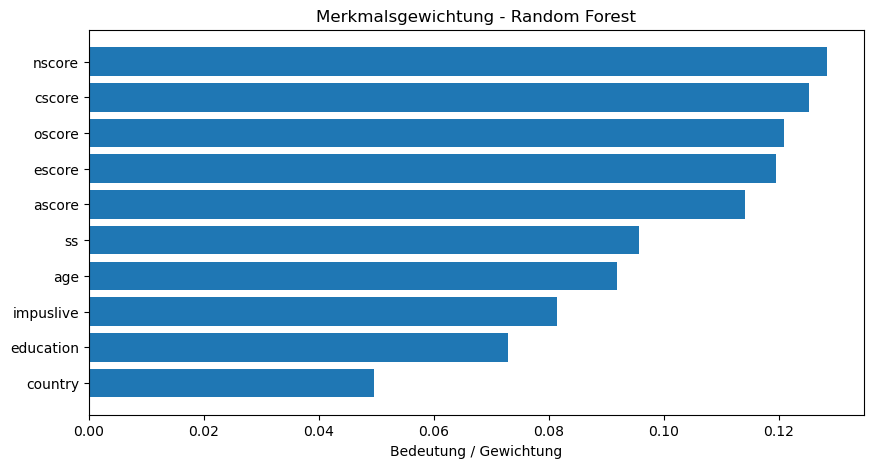

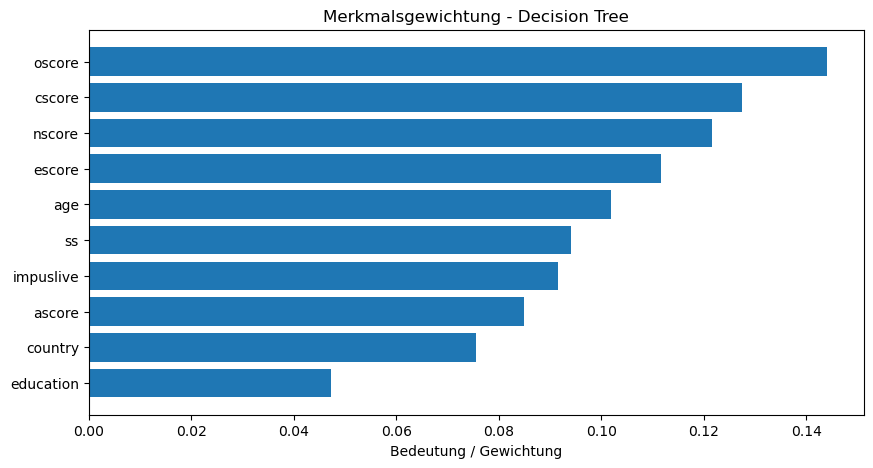

In [58]:
num_features = X_train.shape[1]
feature_names = X_train.columns.tolist() if hasattr(X_train, "columns") else [f"Merkmal {i}" for i in range(num_features)]

def zeige_feature_importance(modellname, gewichtungen):
    if len(gewichtungen) != len(feature_names):
        return
    
    sortierte_indices = np.argsort(gewichtungen)
    plt.figure(figsize=(10, 5))
    plt.title(f"Merkmalsgewichtung - {modellname}")
    plt.barh(range(len(gewichtungen)), gewichtungen[sortierte_indices], align="center")
    plt.yticks(range(len(gewichtungen)), np.array(feature_names)[sortierte_indices])
    plt.xlabel("Bedeutung / Gewichtung")
    plt.show()

if hasattr(rf_model, "feature_importances_"):
    zeige_feature_importance("Random Forest", rf_model.feature_importances_)

if hasattr(dt_model, "feature_importances_"):
    zeige_feature_importance("Decision Tree", dt_model.feature_importances_)


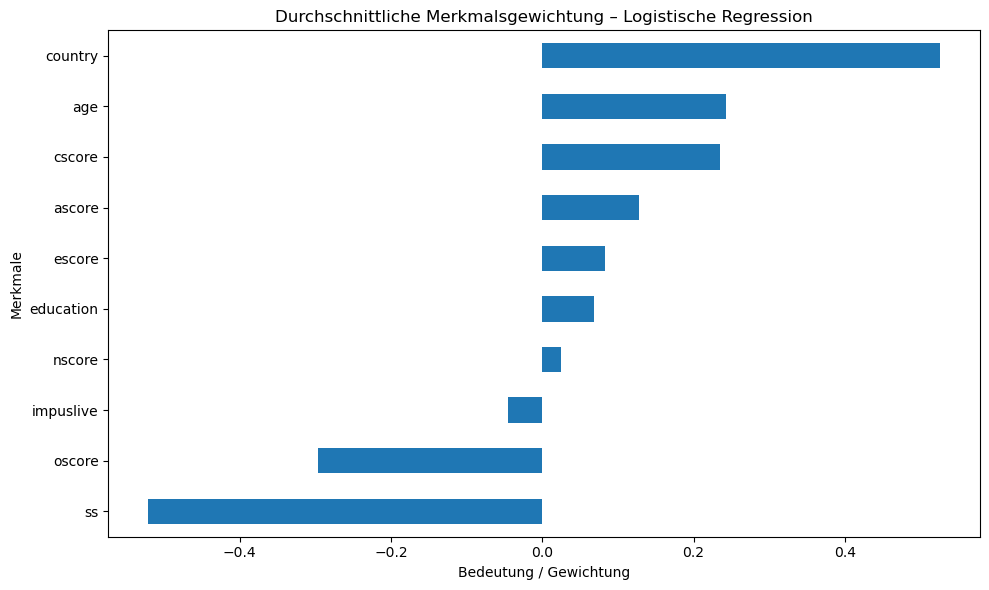

In [59]:
feature_weights = {}

for drug in drug_names:
    model = logreg_models[drug]
    weights = model.coef_[0]
    feature_weights[drug] = weights

feature_weights_df = pd.DataFrame(feature_weights, index=X_train.columns)

mean_weights = feature_weights_df[drug_names].mean(axis=1)
mean_weights.sort_values(ascending=False).plot(kind='barh', figsize=(10, 6))
plt.gca().invert_yaxis()
plt.title('Durchschnittliche Merkmalsgewichtung – Logistische Regression')
plt.xlabel('Bedeutung / Gewichtung')
plt.ylabel('Merkmale')
plt.tight_layout()
plt.show()


### 2.8 Konfusionsmatrizzen

Zur detaillierten Analyse der Modellvorhersagen wird für jede Droge eine Konfusionsmatrix dargestellt.  
Die Matrizzen zeigen, wie oft jede Konsumkategorie korrekt bzw. falsch vorhergesagt wurde.  
So lassen sich typische Fehlklassifikationen und die Modellgenauigkeit je Klasse besser nachvollziehen.

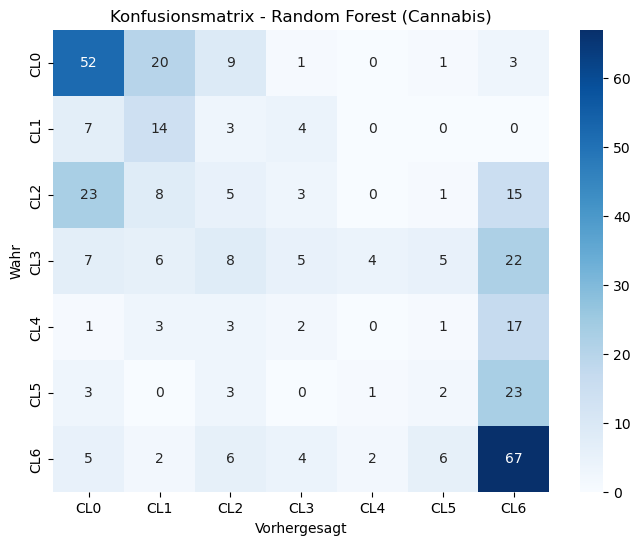

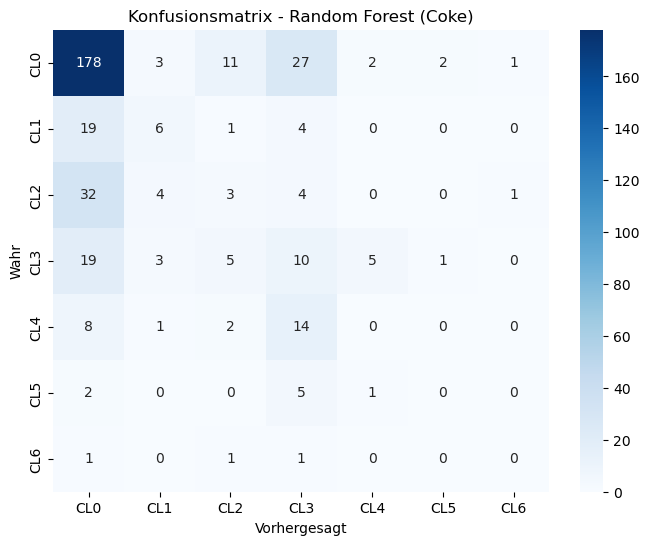

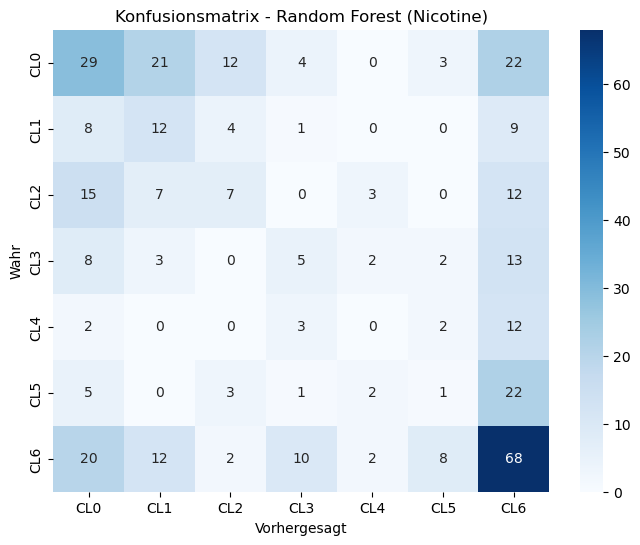

In [60]:
for drug in drug_names:
    conf_matrix = confusion_matrix(y_test[drug], y_pred_rf[drug])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'], yticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'])
    
    plt.title(f"Konfusionsmatrix - Random Forest ({drug.capitalize()})")
    plt.xlabel("Vorhergesagt")
    plt.ylabel("Wahr")
    plt.show()

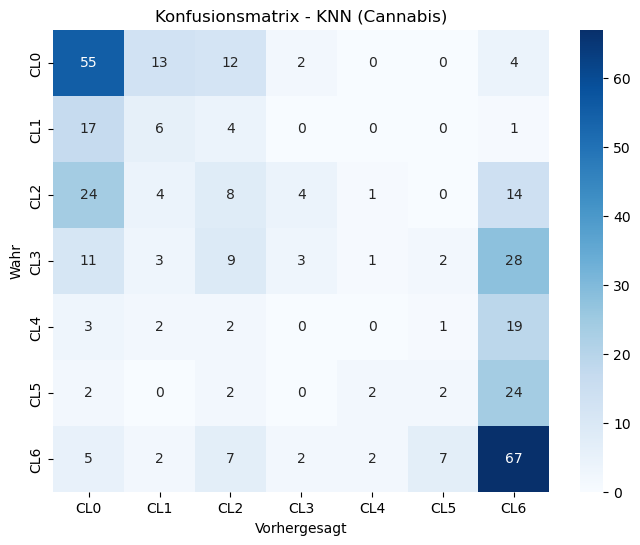

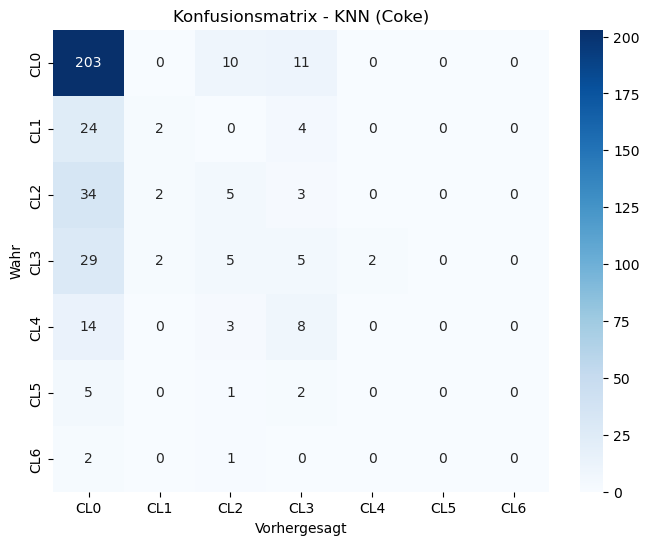

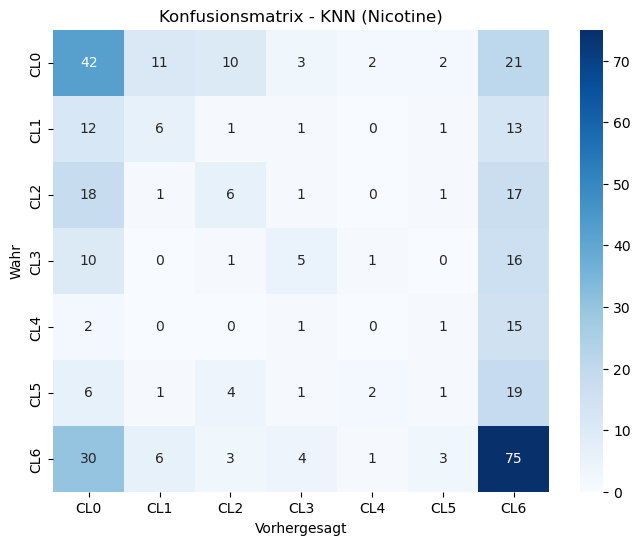

In [61]:
for drug in drug_names:
    conf_matrix_knn = confusion_matrix(y_test[drug], y_pred_knn[drug])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues',
                xticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],
                yticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'])
    plt.title(f"Konfusionsmatrix - KNN ({drug.capitalize()})")
    plt.xlabel("Vorhergesagt")
    plt.ylabel("Wahr")
    plt.show()



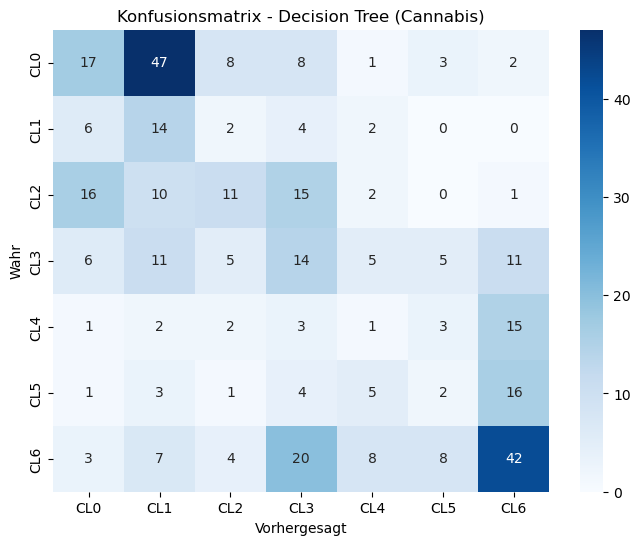

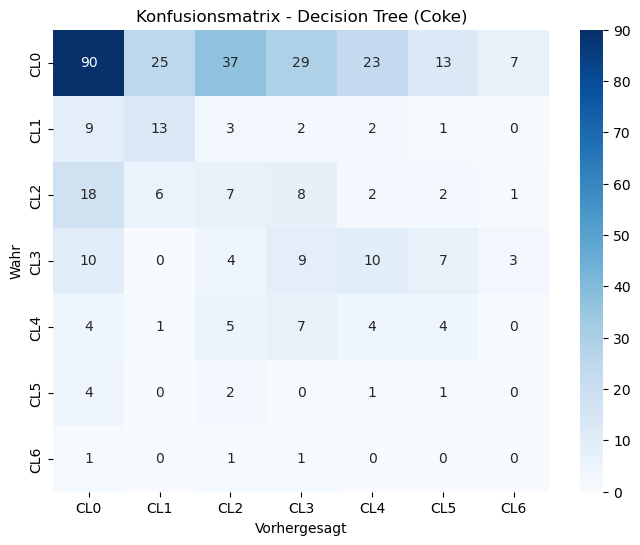

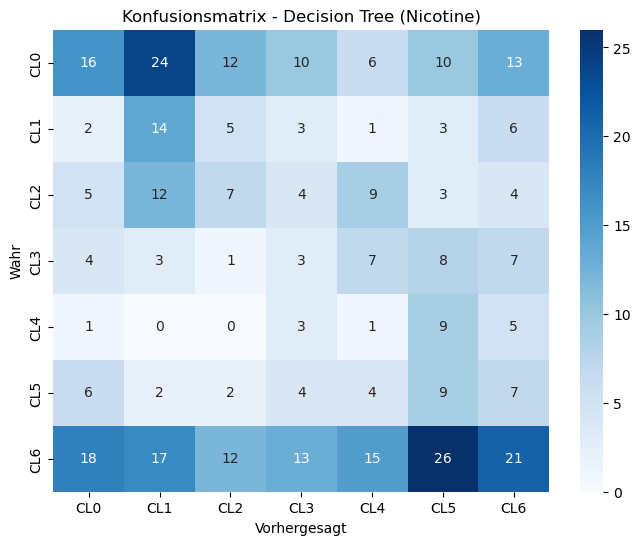

In [62]:
for drug in drug_names:
    conf_matrix_dt = confusion_matrix(y_test[drug], y_pred_dt[drug])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues',
                xticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],
                yticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'])
    plt.title(f"Konfusionsmatrix - Decision Tree ({drug.capitalize()})")
    plt.xlabel("Vorhergesagt")
    plt.ylabel("Wahr")
    plt.show()

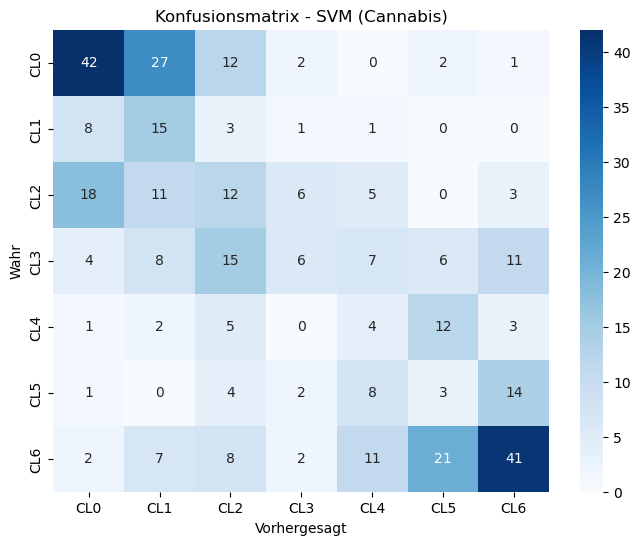

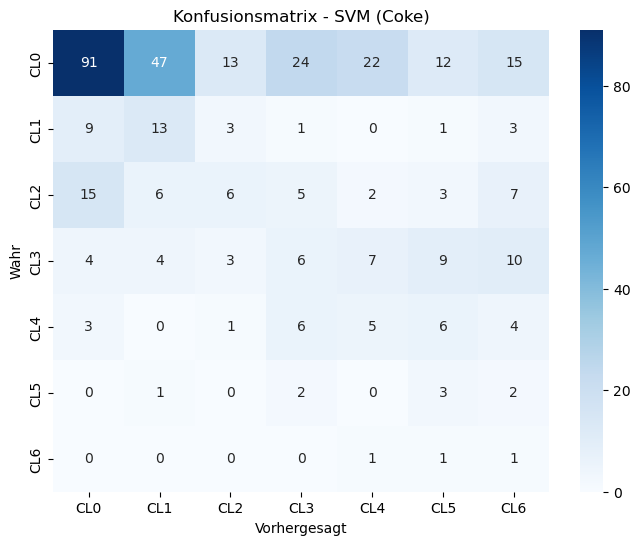

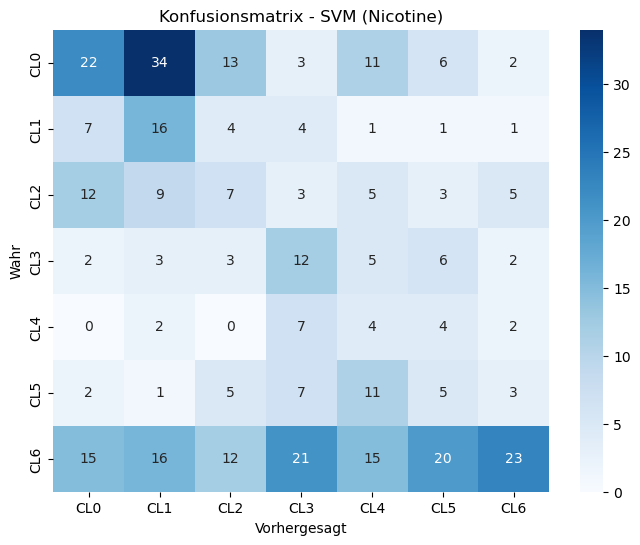

In [63]:
for drug in drug_names:
    conf_matrix_svm = confusion_matrix(y_test[drug], y_pred_svm[drug])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],
                yticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'])
    plt.title(f"Konfusionsmatrix - SVM ({drug.capitalize()})")
    plt.xlabel("Vorhergesagt")
    plt.ylabel("Wahr")
    plt.show()

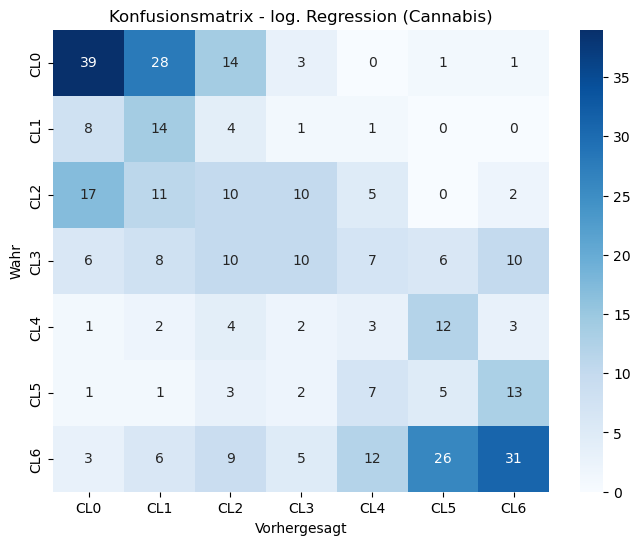

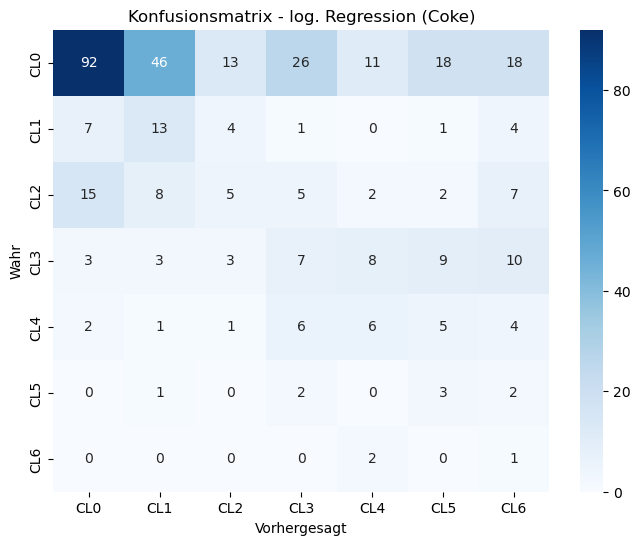

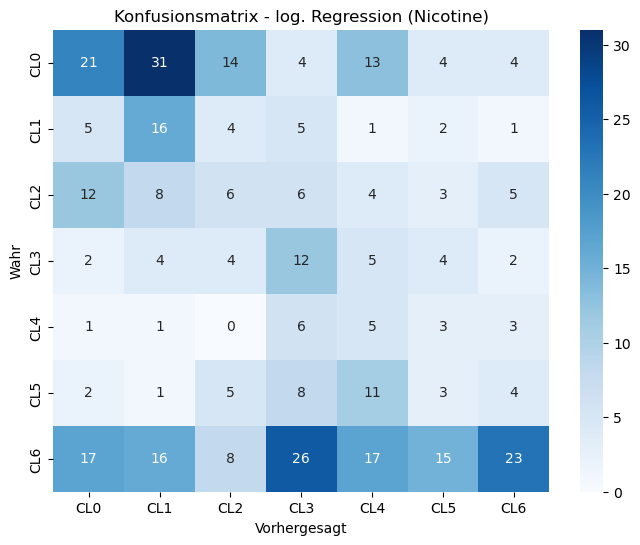

In [64]:
for drug in drug_names:
    conf_matrix_logreg = confusion_matrix(y_test[drug], y_pred_logreg[drug])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues',
                xticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],
                yticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'])
    plt.title(f"Konfusionsmatrix - log. Regression ({drug.capitalize()})")
    plt.xlabel("Vorhergesagt")
    plt.ylabel("Wahr")
    plt.show()